In [1]:
from IPython.display import display

import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

import scipy.optimize
from mosek.fusion import Model, Domain, Expr, ObjectiveSense


In [2]:
nodes = ['B1', 'B2', 'B3']
nnodes = len(nodes)

In [3]:
supply = pd.DataFrame([
    ['G1', 'B1', 100., 12.],
    ['G2', 'B2', 80., 20.],
], columns=['id', 'node', 'capacity (MW)', 'offer ($/MW)']).set_index('id')
nsupply = len(supply)
assert supply.node.isin(nodes).all()
supply

,node,capacity (MW),offer ($/MW)
id,,,
G1,B1,100.0,12.0
G2,B2,80.0,20.0


In [4]:
demand = pd.DataFrame([
    ['D1', 'B2', 100., 40.],
    ['D2', 'B3', 50., 35.],
], columns=['id', 'node', 'demand (MW)', 'bid ($/MW)']).set_index('id')
ndemand = len(demand)
assert demand.node.isin(nodes).all()
demand

,node,demand (MW),bid ($/MW)
id,,,
D1,B2,100.0,40.0
D2,B3,50.0,35.0


In [5]:
lines = pd.DataFrame([
    ['L12', 'B1', 'B2', 100., 500.],
    ['L13', 'B1', 'B3', 100., 500.],
    ['L23', 'B2', 'B3', 100., 500.],
], columns=['id', 'source', 'dest', 'capacity (MW)', 'susceptance (S)']).set_index('id')
nlines = len(lines)
lines

,source,dest,capacity (MW),susceptance (S)
id,,,,
L12,B1,B2,100.0,500.0
L13,B1,B3,100.0,500.0
L23,B2,B3,100.0,500.0


In [6]:
    # with Model('power') as M:
    M = Model('power')
    theta = M.variable('theta', nnodes, Domain.inRange(
        [0.] + [-np.pi] * (nnodes - 1), 
        [0.] + [np.pi] * (nnodes - 1), 
    ))
    pD = M.variable('pD', ndemand, Domain.inRange(0, demand['demand (MW)'].values))
    pG = M.variable('pG', nsupply, Domain.inRange(0, supply['capacity (MW)'].values))
    lambdaD = demand['bid ($/MW)'].values
    lambdaG = supply['offer ($/MW)'].values

    line_constraints = Domain.inRange(-lines['capacity (MW)'].values, 
                                      lines['capacity (MW)'].values)
    line_flows = M.variable('flows', nlines, line_constraints)
    src_idx = [nodes.index(x) for x in lines.source]
    dst_idx = [nodes.index(x) for x in lines.dest]
    phase_diff = Expr.sub(theta.pick(src_idx), theta.pick(dst_idx))
    phase_flow = M.constraint(Expr.sub(line_flows, 
                                       Expr.mulElm(lines['susceptance (S)'].values, phase_diff)),
                              Domain.equalsTo(0.))

    for node in nodes:
        supply_idx = np.flatnonzero(supply.node == node).astype('int32')
        node_supply = Expr.sum(pD.pick(supply_idx))
        demand_idx = np.flatnonzero(demand.node == node).astype('int32')
        node_demand = Expr.sum(pG.pick(demand_idx))
        balance = Expr.sub(node_supply, node_demand)
        direction = [-1 if line.source == node else 
                     1 if line.dest == node else 
                     0 for line_idx, line in lines.iterrows()]
        balance = Expr.add(balance, Expr.dot(direction, line_flows))
        eq = M.constraint(node + 'balance', balance, Domain.equalsTo(0.))

    x = M.variable('x')
    M.constraint('x', Expr.sub(x, Expr.sum(pD.pick([0,0,1]))), Domain.equalsTo(0.))
    obj = Expr.sub(Expr.dot(lambdaD, pD), Expr.dot(lambdaG, pG))
    M.objective('obj', ObjectiveSense.Maximize, obj)
    M.solve()

    demand['consumed (MW)'] = pD.level()
    supply['supplied (MW)'] = pG.level()
    lines['flow (MW)'] = line_flows.level()
    price = eq.dual()[0]
    bus_phase = pd.DataFrame({'volt. angle (rad)': theta.level()}, index=nodes)

In [7]:
display(demand)
display(supply)
print('Clearing price: {:g}'.format(price))
print('Energy scheduled: {:g}'.format(demand['consumed (MW)'].sum()))
print('Objective value: {:g}'.format(M.primalObjValue()))
display(lines)
display(bus_phase)

,node,demand (MW),bid ($/MW),consumed (MW)
id,,,,
D1,B2,100.0,40.0,100.0
D2,B3,50.0,35.0,50.0


,node,capacity (MW),offer ($/MW),supplied (MW)
id,,,,
G1,B1,100.0,12.0,100.0
G2,B2,80.0,20.0,50.0


Clearing price: 20
Energy scheduled: 150
Objective value: 3550


,source,dest,capacity (MW),susceptance (S),flow (MW)
id,,,,,
L12,B1,B2,100.0,500.0,50.0
L13,B1,B3,100.0,500.0,50.0
L23,B2,B3,100.0,500.0,0.0


,volt. angle (rad)
B1,0.0
B2,-0.1
B3,-0.1


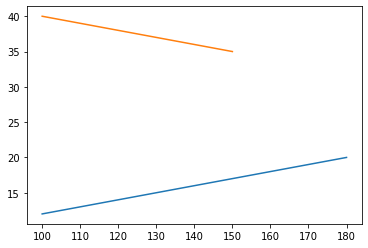

In [8]:
plt.plot(supply['capacity (MW)'].cumsum(), supply['offer ($/MW)'])
plt.plot(demand['demand (MW)'].sort_index(ascending=True).cumsum().sort_index(),
         demand['bid ($/MW)']
        )